In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50     # len(X_train)
epochs = 40
particles = 700
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 688us/step - loss: 2.3035 - accuracy: 0.1000


In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)  
        
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    print("Training Accuracy after Epoch {}: {}".format(str(epoch+1), str(np.round(mean_model_train_acc[-1], 3))))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

Training Accuracy after Epoch 1: 0.117
Training Accuracy after Epoch 2: 0.141
Training Accuracy after Epoch 3: 0.141
Training Accuracy after Epoch 4: 0.161
Training Accuracy after Epoch 5: 0.206
Training Accuracy after Epoch 6: 0.3
Training Accuracy after Epoch 7: 0.404
Training Accuracy after Epoch 8: 0.564
Training Accuracy after Epoch 9: 0.636
Training Accuracy after Epoch 10: 0.684
Training Accuracy after Epoch 11: 0.719
Training Accuracy after Epoch 12: 0.734
Training Accuracy after Epoch 13: 0.746
Training Accuracy after Epoch 14: 0.761
Training Accuracy after Epoch 15: 0.772
Training Accuracy after Epoch 16: 0.783
Training Accuracy after Epoch 17: 0.793
Training Accuracy after Epoch 18: 0.802
Training Accuracy after Epoch 19: 0.811
Training Accuracy after Epoch 20: 0.822
Training Accuracy after Epoch 21: 0.83
Training Accuracy after Epoch 22: 0.835
Training Accuracy after Epoch 23: 0.837
Training Accuracy after Epoch 24: 0.844
Training Accuracy after Epoch 25: 0.852
Training Acc

In [16]:
end_time = time.time()
print("Calculation time: {} minutes.".format((end_time - start_time) / 60))

Calculation time: 247.59540955225626 minutes.


In [17]:
y_pred_dict["model_1"]

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 6.6856854e-12, 2.8142739e-26, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.7281079e-13, 0.0000000e+00, 0.0000000e+00,
        8.9718214e-36, 5.9460221e-30, 1.0000000e+00, 3.3574734e-16,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 8.8543737e-01, 0.0000000e+00,
        0.0000000e+00, 1.1586099e-22, 1.1456264e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.1935738e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        6.0252541e-12, 3.0559331e-34, 9.5806432e-01, 0.0000000e+00,
        1.6961586e-35, 6.0956426e-22],
       [4.6386923e-28, 1.0000000e+00, 0.0000000e+00, 5.9852749e-31,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.00

In [18]:
jacobian_dict["model_1"]

array([[  -0.        ,   -0.99502486,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.99502486,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.99502486,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -1.1230437 ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -1.0383523 ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.99502486,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0

In [19]:
print(np.round(mean_model_train_acc, 3))
print(np.round(mean_model_test_acc, 3))

[0.092 0.117 0.141 0.141 0.161 0.206 0.3   0.404 0.564 0.636 0.684 0.719
 0.734 0.746 0.761 0.772 0.783 0.793 0.802 0.811 0.822 0.83  0.835 0.837
 0.844 0.852 0.856 0.859 0.86  0.862 0.863 0.863 0.864 0.864 0.864 0.864
 0.865 0.865 0.865 0.866 0.866]
[0.1   0.134 0.142 0.124 0.112 0.142 0.222 0.338 0.42  0.47  0.494 0.52
 0.522 0.532 0.53  0.526 0.516 0.51  0.512 0.514 0.524 0.528 0.528 0.528
 0.53  0.534 0.538 0.54  0.54  0.546 0.542 0.542 0.538 0.534 0.538 0.532
 0.53  0.528 0.526 0.526 0.528]


In [20]:
train_acc_dict

{'model_1': [0.1120000034570694,
  0.10499999672174454,
  0.10300000011920929,
  0.10599999874830246,
  0.1080000028014183,
  0.1679999977350235,
  0.2800000011920929,
  0.4390000104904175,
  0.5270000100135803,
  0.5929999947547913,
  0.6039999723434448,
  0.6430000066757202,
  0.6740000247955322,
  0.6850000023841858,
  0.703000009059906,
  0.7170000076293945,
  0.722000002861023,
  0.7329999804496765,
  0.7580000162124634,
  0.765999972820282,
  0.7829999923706055,
  0.7960000038146973,
  0.8090000152587891,
  0.8069999814033508,
  0.8270000219345093,
  0.8209999799728394,
  0.824999988079071,
  0.8360000252723694,
  0.8389999866485596,
  0.8450000286102295,
  0.8500000238418579,
  0.8529999852180481,
  0.8510000109672546,
  0.8510000109672546,
  0.8539999723434448,
  0.8550000190734863,
  0.8550000190734863,
  0.8569999933242798,
  0.859000027179718,
  0.8619999885559082],
 'model_2': [0.07500000298023224,
  0.0860000029206276,
  0.09300000220537186,
  0.10999999940395355,
  0.1289

In [21]:
test_acc_dict

{'model_1': [0.12800000607967377,
  0.09399999678134918,
  0.09600000083446503,
  0.1120000034570694,
  0.11999999731779099,
  0.14000000059604645,
  0.20800000429153442,
  0.33799999952316284,
  0.39800000190734863,
  0.4359999895095825,
  0.46799999475479126,
  0.4860000014305115,
  0.4819999933242798,
  0.4880000054836273,
  0.4819999933242798,
  0.4959999918937683,
  0.5019999742507935,
  0.5059999823570251,
  0.5080000162124634,
  0.5220000147819519,
  0.5260000228881836,
  0.5180000066757202,
  0.5220000147819519,
  0.5199999809265137,
  0.5239999890327454,
  0.5220000147819519,
  0.5260000228881836,
  0.5199999809265137,
  0.527999997138977,
  0.527999997138977,
  0.5299999713897705,
  0.527999997138977,
  0.5320000052452087,
  0.5299999713897705,
  0.5320000052452087,
  0.5299999713897705,
  0.5339999794960022,
  0.5299999713897705,
  0.527999997138977,
  0.5299999713897705],
 'model_2': [0.09000000357627869,
  0.11599999666213989,
  0.09399999678134918,
  0.09399999678134918,


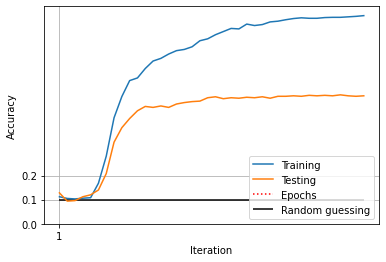

In [22]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

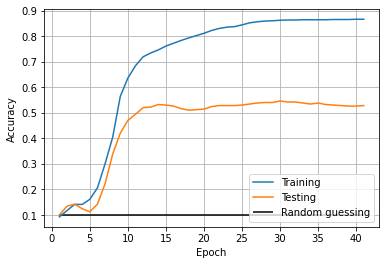

In [23]:
nn_plot_epoch_acc(mean_model_train_acc,
                  mean_model_test_acc,
                  mean_comparison = 0.1,
                  savefig = True,
                  file = "../img/enkf_model_mnist_E{}_B{}_P{}_H{}.png".format(epochs, batch_size, particles, h_0))

In [24]:
nn_save(mean_model, 
        "../models/enkf_model_mnist_E{}_B{}_P{}_H{}.h5".format(epochs, batch_size, particles, h_0))